In [ ]:
import random, os, warnings, math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

### Hardware configuration

In [ ]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 1


# Load data

In [ ]:
train_filepath = '/input/commonlitreadabilityprize/train.csv'
test_filepath = '/input/commonlitreadabilityprize/test.csv'

train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

print(f'Train samples: {len(train)}')
display(train.head())

print(f'Test samples: {len(test)}')
display(test.head())

# removing unused columns
train.drop(['url_legal', 'license'], axis=1, inplace=True)
test.drop(['url_legal', 'license'], axis=1, inplace=True)

Train samples: 2834


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca...",-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the ch...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, p...",-1.054013,0.450007
4,37c1b32fb,NaN,NaN,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one w...",0.247197,0.510845


Test samples: 7


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light w...
1,f0953f0a5,NaN,NaN,"Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn..."
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greeted the eyes of Captain Raymond and his son as they entered the parlor of the adjacent cottage.\nIt wa...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent cell divides into two or more daughter cells. Cell division usually occurs as part of a larger cell...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolving of defects that prevent correct operation of computer software or a system. Debugging tends to b...


# Model parameters

In [ ]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS
EPOCHS = 35
ES_PATIENCE = 7
PATIENCE = 2
N_FOLDS = 5
SEQ_LEN = 256 #300
BASE_MODEL = '/input/huggingface-roberta/roberta-base/'

## Auxiliary functions

In [ ]:
# Datasets utility functions
def custom_standardization(text):
    text = text.lower() # if encoder is uncased
    text = text.strip()
    return text


def sample_target(features, target):
    mean, stddev = target
    sampled_target = tf.random.normal([], mean=tf.cast(mean, dtype=tf.float32), 
                                      stddev=tf.cast(stddev, dtype=tf.float32), dtype=tf.float32)
    
    return (features, sampled_target)
    

def get_dataset(pandas_df, tokenizer, labeled=True, ordered=False, repeated=False, 
                is_sampled=False, batch_size=32, seq_len=128):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    text = [custom_standardization(text) for text in pandas_df['excerpt']]
    
    # Tokenize inputs
    tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
    
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']}, 
                                                      (pandas_df['target'], pandas_df['standard_error'])))
        if is_sampled:
            dataset = dataset.map(sample_target, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']})
        
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


def plot_metrics(history):
    metric_list = list(history.keys())
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    axes = axes.flatten()
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# EDA

In [ ]:
display(train.head())

,id,excerpt,target,standard_error
0,c12129c31,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca...",-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the ch...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the...",-0.580118,0.476676
3,dd1000b26,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, p...",-1.054013,0.450007
4,37c1b32fb,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one w...",0.247197,0.510845


In [ ]:
display(train.sort_values(by=['target']).head())

,id,excerpt,target,standard_error
1705,4626100d8,"The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators sever...",-3.676268,0.623621
1128,493b80aa7,"The Dunwich horror itself came between Lammas and the equinox in 1928, and Dr. Armitage was among those who witnessed its monstrous prologue. He h...",-3.668360,0.571404
1754,fe44cbd14,"The iron cylinder weighs 23 kilogrammes; but, when the current has an intensity of 43 amperes and traverses 15 sections, the stress developed may ...",-3.642892,0.644398
1752,284eaa5ad,As to surface-slope its measurement—from nearly 600 trials—was found to be such a delicate operation that the result would be of doubtful utility....,-3.639936,0.603819
1720,9e9eacb49,"The tree is dioecious, bearing male catkins on one plant, female on another. All the female trees in Europe are believed to have originated from a...",-3.636834,0.606822


In [ ]:
display(train.sort_values(by=['target'], ascending=False).head())

,id,excerpt,target,standard_error
2829,25ca8f498,"When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs li...",1.711390,0.646900
981,849971671,"For her last birthday, Sisanda had a special treat – her parents got permission for her to have a party at the game reserve. The giraffes at the r...",1.597870,0.596349
808,8f35441e3,"Every day, Emeka's father took him to school in his car. He also brought Emeka home after school. One afternoon on their way home, Emeka's father ...",1.583847,0.624776
1014,7a1d484be,"More people came to the bus stop just before 9am. Half an hour later they are all still waiting. Sam is worried. ""Maybe the bus broke down,"" he th...",1.541672,0.606997
1066,016913371,"Grandma's garden was wonderful. It was full of sorghum, millet, and cassava. But best of all were the bananas. Although Grandma had many grandchil...",1.467665,0.599600


## Label distribution

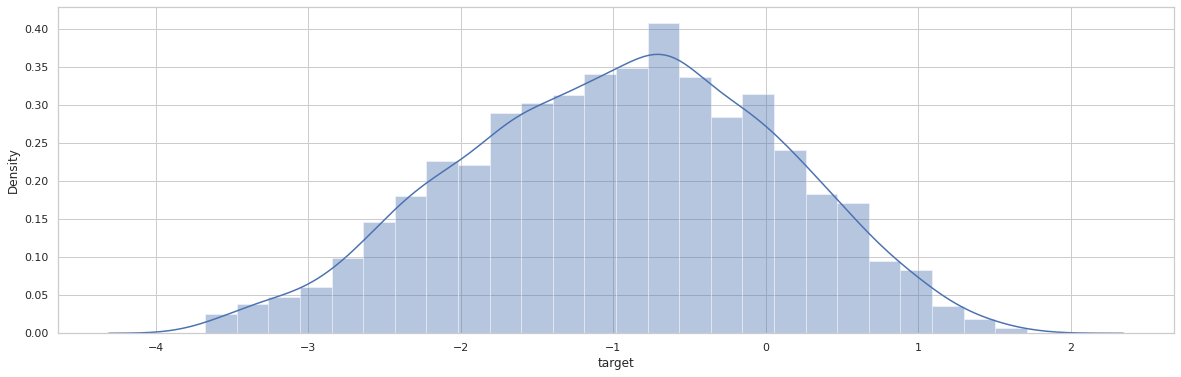

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['target'], ax=ax)
plt.show()

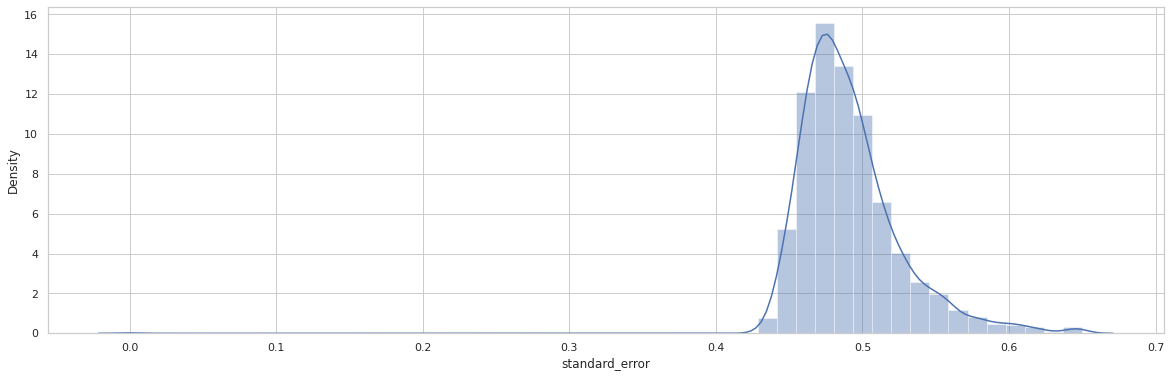

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['standard_error'], ax=ax)
plt.show()

In [ ]:
print(f"standard_error values >= than 0.4: {len(train[train['standard_error'] >= 0.4])}")
print(f"standard_error values < than 0.4: {len(train[train['standard_error'] < 0.4])}")

standard_error values >= than 0.4: 2833
standard_error values < than 0.4: 1


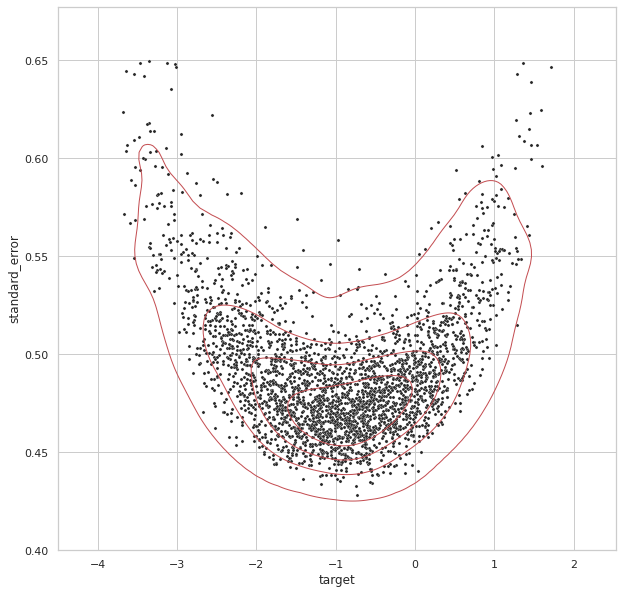

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=train['target'], y=train['standard_error'], s=10, color=".15")
sns.kdeplot(x=train['target'], y=train['standard_error'], levels=5, color="r", linewidths=1)
plt.ylim([0.4, None])
plt.show()

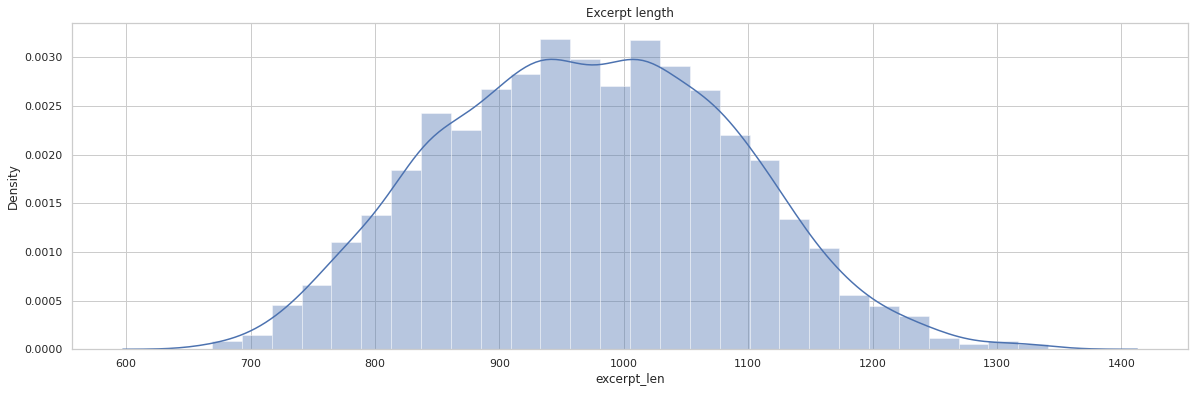

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
train['excerpt_len'] = train['excerpt'].apply(lambda x : len(x))
train['excerpt_wordCnt'] = train['excerpt'].apply(lambda x : len(x.split(' ')))
train['excerpt_tokenCnt'] = train['excerpt'].apply(lambda x : len(tokenizer.encode(x, add_special_tokens=False)))

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_len'], ax=ax).set_title('Excerpt length')
plt.show()

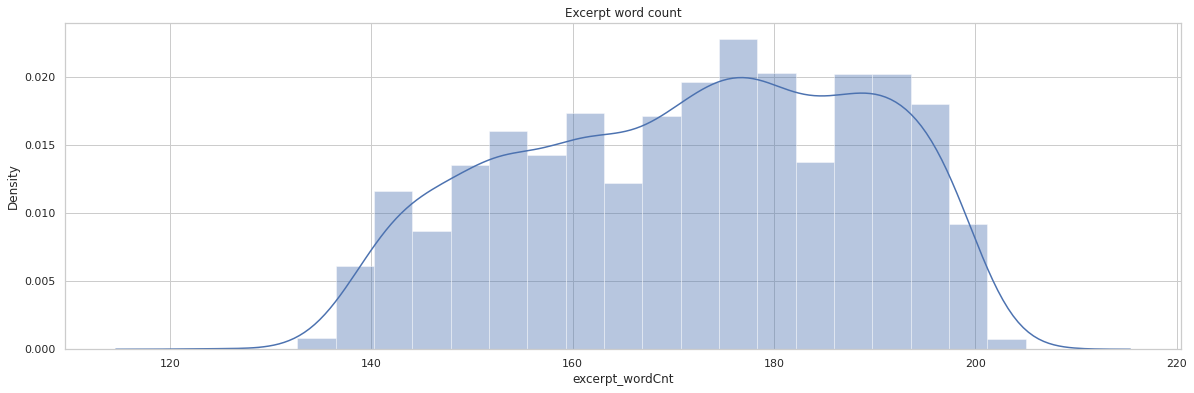

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_wordCnt'], ax=ax).set_title('Excerpt word count')
plt.show()

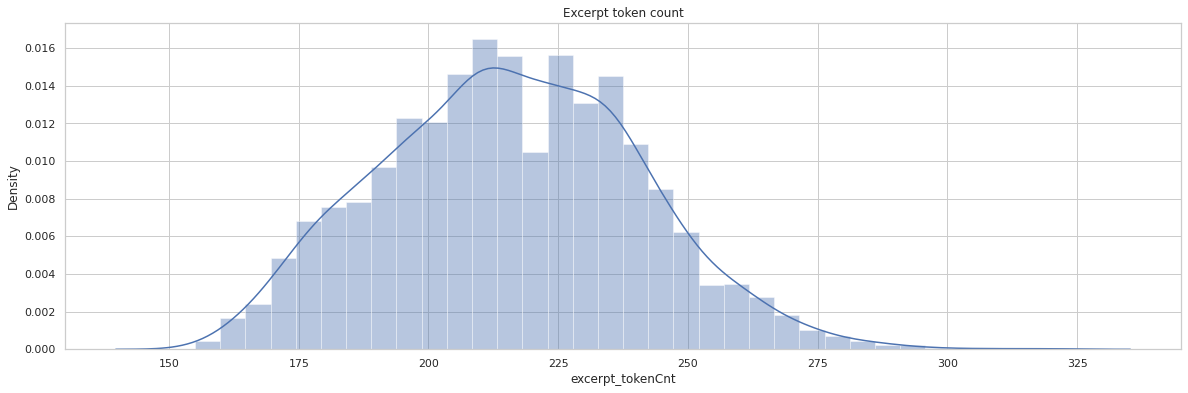

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_tokenCnt'], ax=ax).set_title('Excerpt token count')
plt.show()

# Model

In [ ]:
def model_fn(encoder, seq_len=256):
    input_ids = L.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
    input_attention_mask = L.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    outputs = encoder({'input_ids': input_ids, 
                       'attention_mask': input_attention_mask})
    
    model = Model(inputs=[input_ids, input_attention_mask], outputs=outputs)

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.MeanSquaredError(), 
                  metrics=[metrics.RootMeanSquaredError()])
    
    return model


with strategy.scope():
    encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
    model = model_fn(encoder, SEQ_LEN)
    
model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_sequence_classif TFSequenceClassifier 124646401   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
Total params: 124,646,401
Trainable params: 124,646,401
Non-trainable params: 0
__________________________________________________________________________________________________


# Training

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []; test_pred = []

for fold,(idxT, idxV) in enumerate(skf.split(train)):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')

    # Model
    K.clear_session()
    with strategy.scope():
        encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
        model = model_fn(encoder, SEQ_LEN)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_root_mean_squared_error', mode='min', 
                                 save_best_only=True, save_weights_only=True)

    # Train
    history = model.fit(x=get_dataset(train.loc[idxT], tokenizer, repeated=True, is_sampled=True, 
                                      batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        validation_data=get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                                                    batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        steps_per_epoch=50, 
                        callbacks=[es, checkpoint], 
                        epochs=EPOCHS,  
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.load_weights(model_path)
    
    # Results
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_root_mean_squared_error']):.4f}")

    # OOF predictions
    valid_ds = get_dataset(train.loc[idxV], tokenizer, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    oof_labels.append([target[0].numpy() for sample, target in iter(valid_ds.unbatch())])
    x_oof = valid_ds.map(lambda sample, target: sample)
    oof_pred.append(model.predict(x_oof)['logits'])

    # Test predictions
    test_ds = get_dataset(test, tokenizer, labeled=False, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    x_test = test_ds.map(lambda sample: sample)
    test_pred.append(model.predict(x_test)['logits'])


FOLD: 1
TRAIN: 2267 VALID: 567


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 40s - loss: 1.3941 - root_mean_squared_error: 1.1807 - val_loss: 0.9639 - val_root_mean_squared_error: 0.9818
Epoch 2/35
50/50 - 20s - loss: 0.9396 - root_mean_squared_error: 0.9693 - val_loss: 0.6067 - val_root_mean_squared_error: 0.7789
Epoch 3/35
50/50 - 21s - loss: 0.6976 - root_mean_squared_error: 0.8352 - val_loss: 0.4106 - val_root_mean_squared_error: 0.6408
Epoch 4/35
50/50 - 20s - loss: 0.6128 - root_mean_squared_error: 0.7828 - val_loss: 0.4983 - val_root_mean_squared_error: 0.7059
Epoch 5/35
50/50 - 20s - loss: 0.6612 - root_mean_squared_error: 0.8131 - val_loss: 0.5380 - val_root_mean_squared_error: 0.7335
Epoch 6/35
50/50 - 21s - loss: 0.5795 - root_mean_squared_error: 0.7612 - val_loss: 0.4049 - val_root_mean_squared_error: 0.6363
Epoch 7/35
50/50 - 20s - loss: 0.5913 - root_mean_squared_error: 0.7690 - val_loss: 0.4187 - val_root_mean_squared_error: 0.6471
Epoch 8/35
50/50 - 21s - loss: 0.5307 - root_mean_squared_error: 0.7285 - val_loss: 0.3210 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 39s - loss: 1.2807 - root_mean_squared_error: 1.1317 - val_loss: 0.7152 - val_root_mean_squared_error: 0.8457
Epoch 2/35
50/50 - 21s - loss: 0.9164 - root_mean_squared_error: 0.9573 - val_loss: 0.9236 - val_root_mean_squared_error: 0.9610
Epoch 3/35
50/50 - 21s - loss: 0.8972 - root_mean_squared_error: 0.9472 - val_loss: 0.4259 - val_root_mean_squared_error: 0.6526
Epoch 4/35
50/50 - 20s - loss: 0.7243 - root_mean_squared_error: 0.8511 - val_loss: 0.6439 - val_root_mean_squared_error: 0.8024
Epoch 5/35
50/50 - 20s - loss: 0.5963 - root_mean_squared_error: 0.7722 - val_loss: 0.4078 - val_root_mean_squared_error: 0.6386
Epoch 6/35
50/50 - 20s - loss: 0.6583 - root_mean_squared_error: 0.8114 - val_loss: 0.3469 - val_root_mean_squared_error: 0.5890
Epoch 7/35
50/50 - 20s - loss: 0.6208 - root_mean_squared_error: 0.7879 - val_loss: 0.4235 - val_root_mean_squared_error: 0.6508
Epoch 8/35
50/50 - 21s - loss: 0.5754 - root_mean_squared_error: 0.7585 - val_loss: 0.3505 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 38s - loss: 1.3688 - root_mean_squared_error: 1.1700 - val_loss: 0.7758 - val_root_mean_squared_error: 0.8808
Epoch 2/35
50/50 - 21s - loss: 1.0355 - root_mean_squared_error: 1.0176 - val_loss: 0.9783 - val_root_mean_squared_error: 0.9891
Epoch 3/35
50/50 - 21s - loss: 0.9142 - root_mean_squared_error: 0.9561 - val_loss: 0.5809 - val_root_mean_squared_error: 0.7621
Epoch 4/35
50/50 - 21s - loss: 0.7270 - root_mean_squared_error: 0.8527 - val_loss: 0.4546 - val_root_mean_squared_error: 0.6743
Epoch 5/35
50/50 - 20s - loss: 0.6947 - root_mean_squared_error: 0.8335 - val_loss: 0.3868 - val_root_mean_squared_error: 0.6220
Epoch 6/35
50/50 - 21s - loss: 0.6299 - root_mean_squared_error: 0.7937 - val_loss: 0.4895 - val_root_mean_squared_error: 0.6996
Epoch 7/35
50/50 - 21s - loss: 0.6288 - root_mean_squared_error: 0.7930 - val_loss: 0.3913 - val_root_mean_squared_error: 0.6255
Epoch 8/35
50/50 - 20s - loss: 0.6240 - root_mean_squared_error: 0.7899 - val_loss: 0.4602 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 39s - loss: 1.2488 - root_mean_squared_error: 1.1175 - val_loss: 0.7671 - val_root_mean_squared_error: 0.8758
Epoch 2/35
50/50 - 21s - loss: 0.8230 - root_mean_squared_error: 0.9072 - val_loss: 0.5835 - val_root_mean_squared_error: 0.7639
Epoch 3/35
50/50 - 20s - loss: 0.6346 - root_mean_squared_error: 0.7966 - val_loss: 0.5101 - val_root_mean_squared_error: 0.7142
Epoch 4/35
50/50 - 21s - loss: 0.6557 - root_mean_squared_error: 0.8097 - val_loss: 0.3937 - val_root_mean_squared_error: 0.6275
Epoch 5/35
50/50 - 21s - loss: 0.6743 - root_mean_squared_error: 0.8211 - val_loss: 0.5143 - val_root_mean_squared_error: 0.7171
Epoch 6/35
50/50 - 20s - loss: 0.6549 - root_mean_squared_error: 0.8093 - val_loss: 0.4747 - val_root_mean_squared_error: 0.6890
Epoch 7/35
50/50 - 20s - loss: 0.6076 - root_mean_squared_error: 0.7795 - val_loss: 0.3120 - val_root_mean_squared_error: 0.5586
Epoch 8/35
50/50 - 21s - loss: 0.5145 - root_mean_squared_error: 0.7173 - val_loss: 0.3042 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 - 39s - loss: 1.3758 - root_mean_squared_error: 1.1729 - val_loss: 0.8404 - val_root_mean_squared_error: 0.9168
Epoch 2/35
50/50 - 21s - loss: 1.0233 - root_mean_squared_error: 1.0116 - val_loss: 0.5314 - val_root_mean_squared_error: 0.7290
Epoch 3/35
50/50 - 20s - loss: 0.8320 - root_mean_squared_error: 0.9121 - val_loss: 0.4063 - val_root_mean_squared_error: 0.6374
Epoch 4/35
50/50 - 20s - loss: 0.7649 - root_mean_squared_error: 0.8746 - val_loss: 0.4257 - val_root_mean_squared_error: 0.6524
Epoch 5/35
50/50 - 21s - loss: 0.7215 - root_mean_squared_error: 0.8494 - val_loss: 0.3836 - val_root_mean_squared_error: 0.6194
Epoch 6/35
50/50 - 20s - loss: 0.5353 - root_mean_squared_error: 0.7316 - val_loss: 0.3255 - val_root_mean_squared_error: 0.5706
Epoch 7/35
50/50 - 20s - loss: 0.6168 - root_mean_squared_error: 0.7853 - val_loss: 0.3110 - val_root_mean_squared_error: 0.5577
Epoch 8/35
50/50 - 21s - loss: 0.6014 - root_mean_squared_error: 0.7755 - val_loss: 0.3004 - val_

## Model loss and metrics graph


FOLD: 1


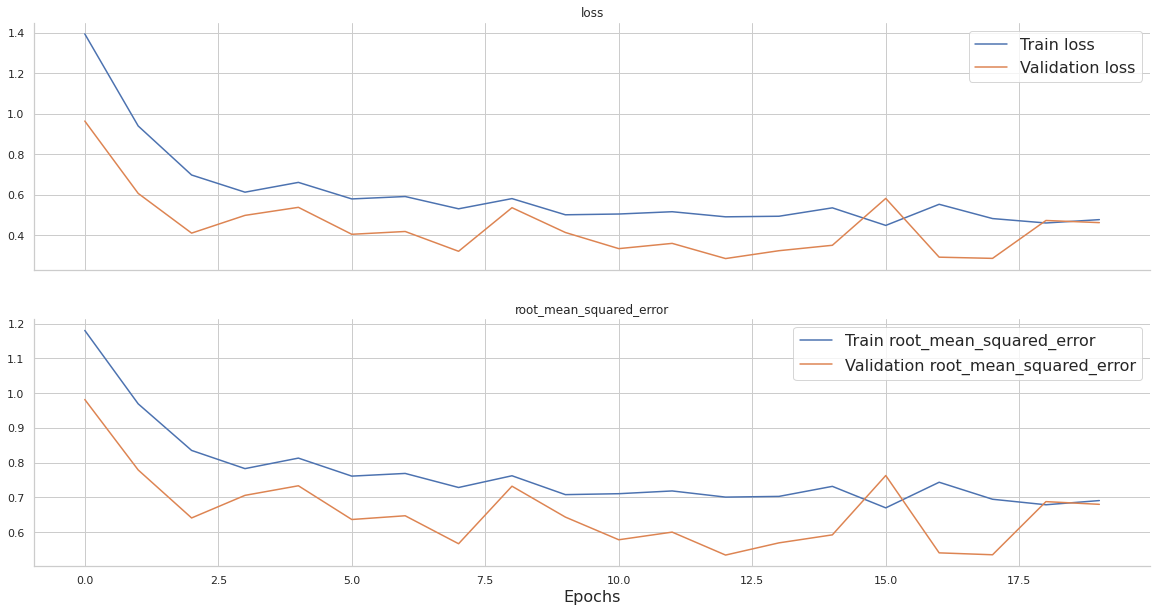


FOLD: 2


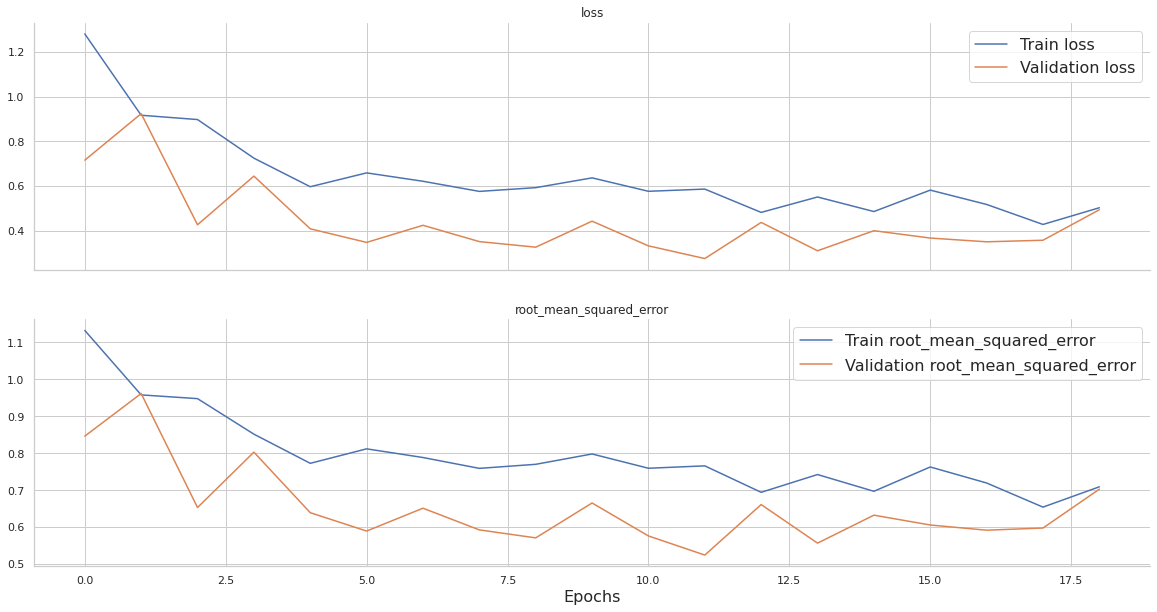


FOLD: 3


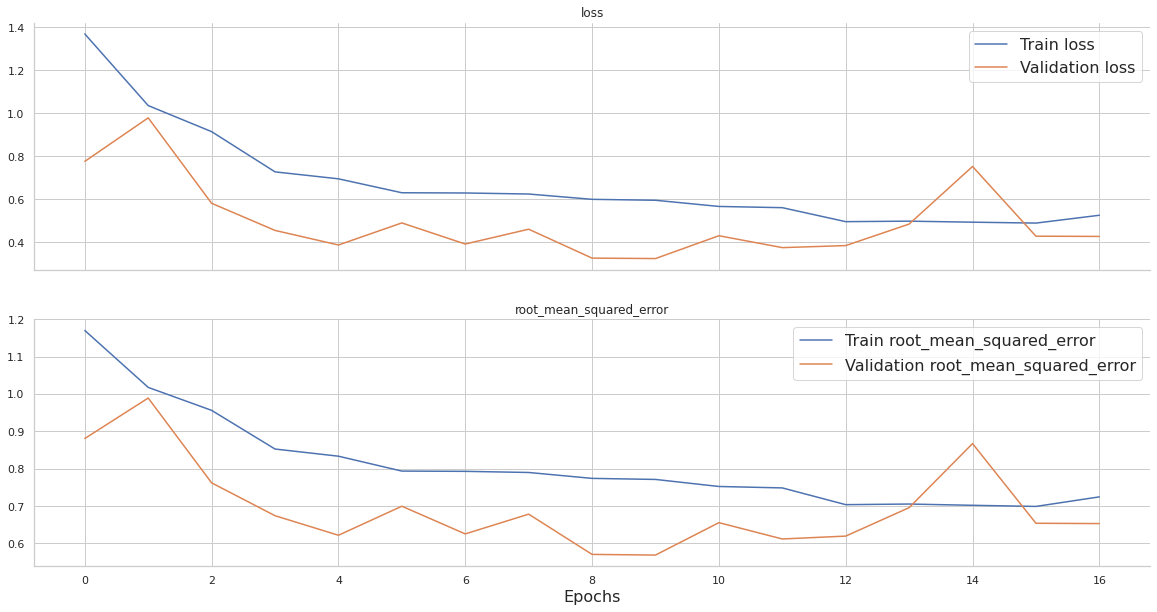


FOLD: 4


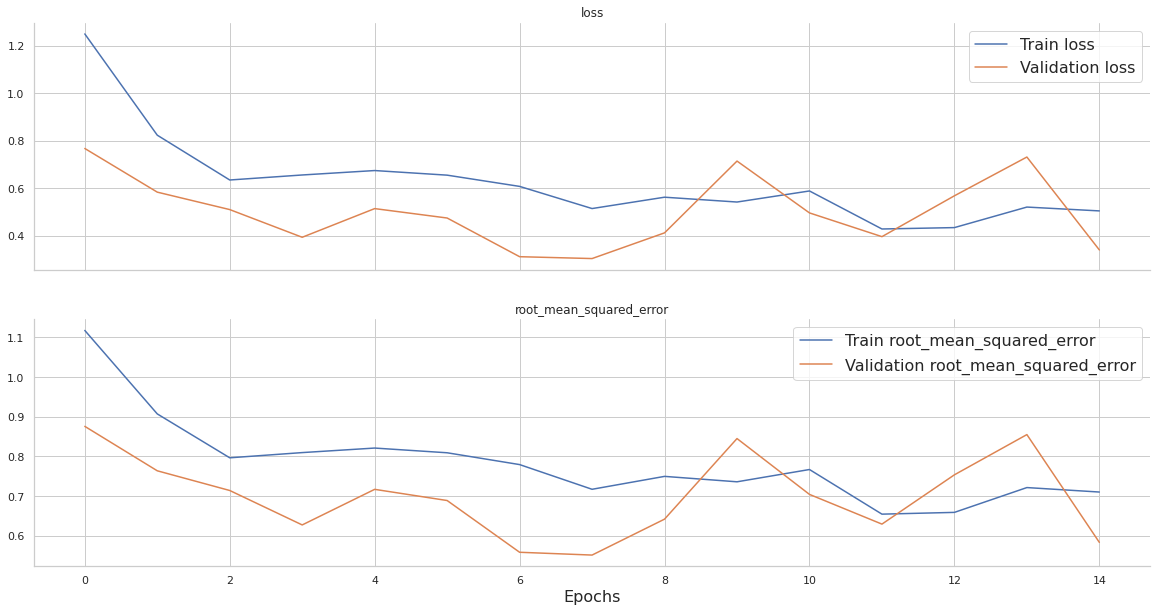


FOLD: 5


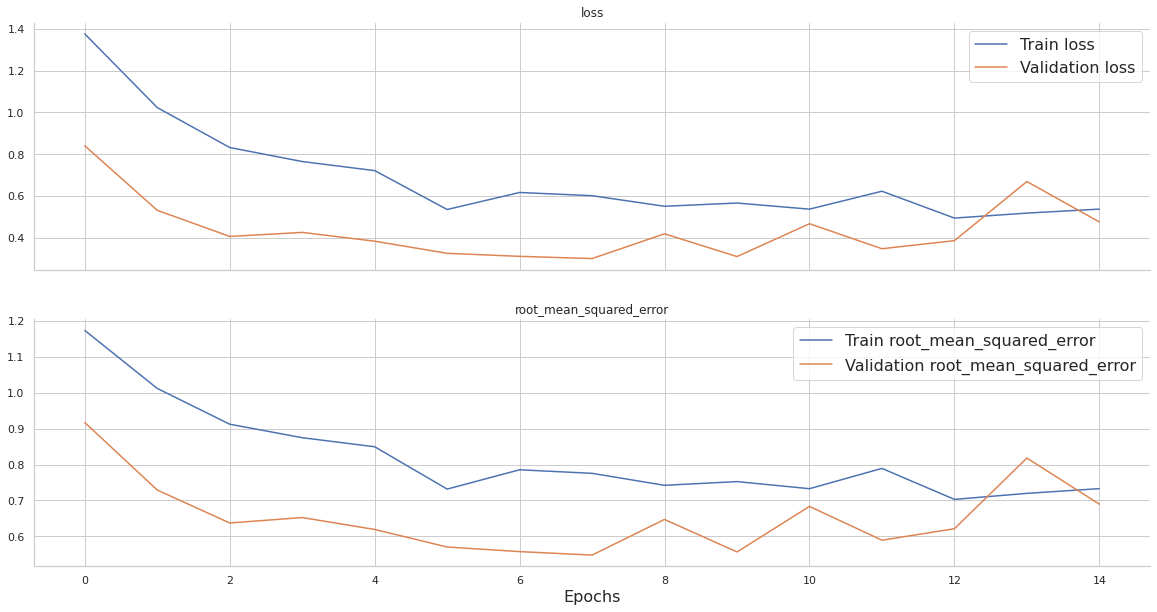

In [ ]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation


In [ ]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)


for fold, history in enumerate(history_list):
    print(f"FOLD {fold+1} RMSE: {np.min(history['val_root_mean_squared_error']):.4f}")
    
print(f'OOF RMSE: {mean_squared_error(y_true, y_preds, squared=False):.4f}')

FOLD 1 RMSE: 0.5339
FOLD 2 RMSE: 0.5240
FOLD 3 RMSE: 0.5689
FOLD 4 RMSE: 0.5515
FOLD 5 RMSE: 0.5481
OOF RMSE: 0.5455


### **Error analysis**

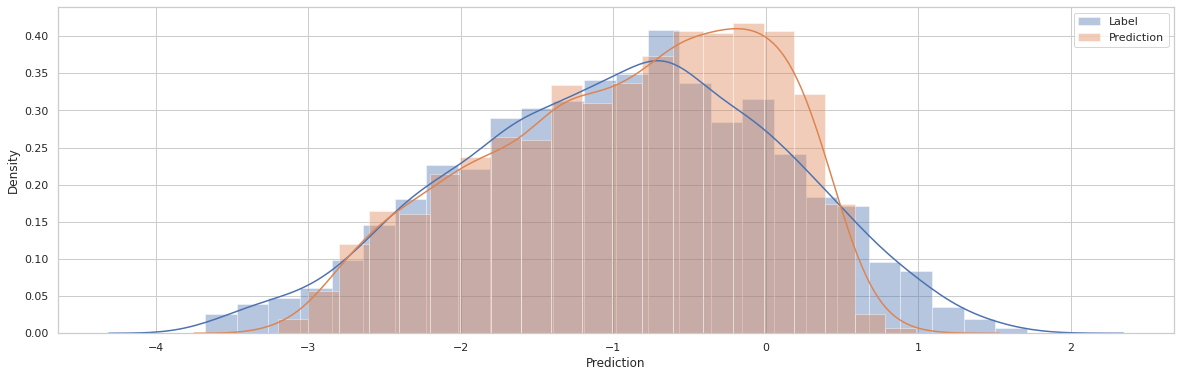

In [ ]:
preds_df = pd.DataFrame({'Label': y_true, 'Prediction': y_preds[:,0]})

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(preds_df['Label'], ax=ax, label='Label')
sns.distplot(preds_df['Prediction'], ax=ax, label='Prediction')
ax.legend()
plt.show()

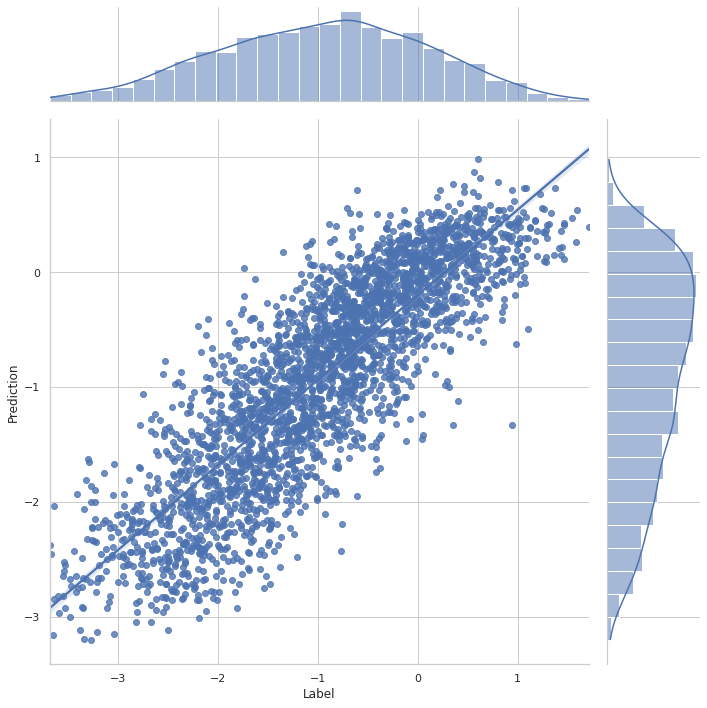

In [ ]:
sns.jointplot(data=preds_df, x='Label', y='Prediction', kind='reg', height=10)
plt.show()

# Test set predictions

In [ ]:
submission = test[['id']]
submission['target'] = np.mean(test_pred, axis=0)
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

,id,target
0,c0f722661,-0.517206
1,f0953f0a5,-0.299399
2,0df072751,-0.464269
3,04caf4e0c,-2.583473
4,0e63f8bea,-1.733788
5,12537fe78,-1.206745
6,965e592c0,0.454707
